<a href="https://colab.research.google.com/github/proffranciscofernando/DataScience-PUCRio-MVP1/blob/main/MVP1_PUCRio_Francisco_Fernando.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pós-graduação em Data Science e Analytics - PUC Rio
## Sprint 1: Análise de Dados e Boas Práticas
## MVP enviado em 12/12/2023
## Francisco Fernando Roberto Pereira
#### francisco.fernando@ufpe.br
#### franciscofernando1989@gmail.com

# 1. Definição do Problema

## 1.1. Dados e Objetivos do Trabalho



O dataset usado neste projeto será o **Wind Turbine SCADA** obtido do sistema SCADA (*Supervisory Control and Data Acquisition*) de um aerogerador proveniente de um parque eólico na Turkia durante o ano de 2018. Seu objetivo é fornecer dados de séries temporais para a construção de modelos preditivos para estimar a energia eólica gerada pelo aerogerador.

Os dados sobre os atributos foram aquisitados pelo sistema SCADA do aerogerador em intervalos de 10 minutos durante todo o ano de 2018. A descrição dos atributos é apresentada a seguir:
1. **Date/Time** - Data (em formato DD MM AAAA) e hora em intervalos de 10 minutos;
2. **LV Active Power (kW)** - Potência produzida pelo aerogerador num dado instante;
3. **Wind Speed (m/s)** - Velocidade do vento na altura do cubo do aerogerador (velocidade utilizada para a geração de eletricidade);
4. **Theoretical Power Curve (kWh)** - Valores teóricos de potência (fornecidos pelo fabricante) que o aerogerador produz com uma dada velocidade do vento;
5. **Wind Direction (°)** - Direção do vento na altura do cubo do aerogerador (aerogeradores se posicionam automaticamente para esta direção);

Para mais detalhes sobre este dataset, consulte: https://www.kaggle.com/datasets/berkerisen/wind-turbine-scada-dataset

Como o objetivo é fazer a previsão de uma variável contínua (produção de energia) com base em outras variáveis (potência teórica, direção e velocidade do vento), trata-se portanto de um problema em si é de aprendizado supervisionado, pois o modelo será treinado usando pares de entrada-saída. Nesse caso, com as séries temporais históricas de dados de produção de energia eólica, o modelo será treinado para aprender a relação entre os atributos selecionados (features) e a produção de energia (target).

Especificamente para esse MVP, os objetivos são:
*   Visualizar o dataset de várias maneiras diferentes para ganhar um entendimento geral dos dados;
*   Identificar e tratar valores *outliers*;
*   Separar adequadamente os dados para a fase de construção, treinamento e experimentação de modelos;

## 1.2. Premissas do Problema e Limitações dos Dados

Ao abordar um problema de previsão de produção de energia eólica com base em séries temporais, podemos considerar as seguintes premissas:

*    Relação entre velocidade do vento e produção de energia: a hipótese fundamental pode ser que a produção de energia eólica está significativamente relacionada à velocidade do vento. Geralmente, espera-se que haja uma relação positiva entre a velocidade do vento e a produção de energia.

*    Efeito da direção do vento: a direção do vento também pode desempenhar um papel na produção de energia. Dependendo da orientação das turbinas eólicas, a direção do vento pode afetar a eficiência da produção.

*    Padrões temporais: é razoável supor que existam padrões sazonais ou temporais na produção de energia eólica. Por exemplo, certas épocas do ano podem ter ventos mais fortes, levando a uma maior produção.

O impacto de outras variáveis ambientais (como, por exemplo, temperatura, pressão atmosférica, umidade, etc) na produção de energia eólica não será levado em consideração no futuro modelo. Isso é uma limitação desse dataset, que não inclui essas variáveis.

Além disso, há a necessidade de estabelecermos os limites mínimo e máximo para a velocidade dos ventos. Dessa forma, temos:

1. Velocidade de corte (cut-in speed): para que um aerogerador produza eletricidade, é necessário que o vento tenha uma velocidade mínima, a partir da qual as turbinas eólicas começam a girar e a gerar eletricidade. Essa velocidade é conhecida como "cut-in speed". Para essa análise, a velocidade de corte será de 3 m/s.

2. Velocidade máxima (cut-out speed): por motivos de segurança, há um limite máximo de velocidade de vento para o equipamento. Para esse trabalho, a velocidade máxima será de 25 m/s.

Esses limites foram estabelecidos de acordo com as informações de operação da empresa Engie Wind Power (2023).

Fonte: [Wind Power | Engie](https://corporate.engie.be/en/energy/wind-power)



# 2. Análise de dados

## 2.1. Configuração Inicial

In [1]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms # para tratamento de missings
from matplotlib import cm
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

## 2.2. Carga de Dados

Iremos usar o pacote Pandas (Python Data Analysis Library) para carregar de um arquivo .csv sem cabeçalho disponível online.

Com o dataset carregado, iremos explorá-lo um pouco.

In [3]:
# Carregar arquivo csv usando Pandas usando uma URL

# Informar a URL de importação do dataset
url = "https://raw.githubusercontent.com/proffranciscofernando/DataScience-PUCRio-MVP1/main/windturbine_scada_dataset.csv"

# Informar o cabeçalho das colunas
colunas = ['Date/Time', 'Active Power (kW)', 'Wind Speed (m/s)', 'Theoretical Power (kWh)', 'Wind Direction (°)']

# Ler o arquivo utilizando as colunas informadas
dataset = pd.read_csv(url, names=colunas, skiprows=1, delimiter=',')

## 2.3. Estatísticas Descritivas

Vamos iniciar examinando as dimensões do dataset, suas informações e alguns exemplos de linhas.

In [4]:
# Mostra as dimensões do dataset
instancias, atributos = dataset.shape
print(f'O dataset tem {instancias} instâncias e {atributos} atributos' )

O dataset tem 50530 instâncias e 5 atributos


In [5]:
# Mostra as informações do dataset
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date/Time                50530 non-null  object 
 1   Active Power (kW)        50530 non-null  float64
 2   Wind Speed (m/s)         50530 non-null  float64
 3   Theoretical Power (kWh)  50530 non-null  float64
 4   Wind Direction (°)       50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB
None


In [6]:
# Mostra as 10 primeiras linhas do dataset
dataset.head(10)

,Date/Time,Active Power (kW),Wind Speed (m/s),Theoretical Power (kWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
5,01 01 2018 00:50,402.391998,5.604052,499.436385,264.578613
6,01 01 2018 01:00,447.605713,5.793008,557.372363,266.163605
7,01 01 2018 01:10,387.242188,5.306050,414.898179,257.949493
8,01 01 2018 01:20,463.651215,5.584629,493.677652,253.480698
9,01 01 2018 01:30,439.725708,5.523228,475.706783,258.723785


In [7]:
# Mostra as 10 últimas linhas do dataset
dataset.tail(10)

,Date/Time,Active Power (kW),Wind Speed (m/s),Theoretical Power (kWh),Wind Direction (°)
50520,31 12 2018 22:20,2771.110107,10.154550,2884.512812,82.335197
50521,31 12 2018 22:30,3333.819092,12.067660,3532.081496,81.985901
50522,31 12 2018 22:40,3455.282959,12.195660,3549.150371,82.210617
50523,31 12 2018 22:50,3429.021973,12.492510,3578.567804,82.111870
50524,31 12 2018 23:00,3514.269043,12.559170,3583.288363,80.495262
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913
50529,31 12 2018 23:50,2820.466064,9.979332,2779.184096,82.274620


Nada de anormal foi detectado ao analisarmos as 10 primeiras e 10 últimas linhas do dataset. Para esse pequeno recorte dos dados, não há *missings*, *outliers* or inconsistências. Para uma análise mais aprofundada, teremos que usar outras formas de visualização.

In [8]:
# Verifica o tipo de dataset de cada atributo
dataset.dtypes

Date/Time                   object
Active Power (kW)          float64
Wind Speed (m/s)           float64
Theoretical Power (kWh)    float64
Wind Direction (°)         float64
dtype: object

É sempre importante verificar o tipo do atributos do dataset, pois pode ser necessário realizar conversões. Já fizemos anteriormente com o comando info, mas vamos ver uma outra forma de verificar a natureza de cada atributo e então exibir um resumo estatístico do dataset.

Nesse contexto, notamos que todos os atributos são do tipo "float64", com excessão do "Date/Time", que está no formato "object". Isso significa que esses dados estão sendo tratados como texto, ao invés de datas. Para realizar análises temporais eficazes, é essencial convertermos essa coluna para o formato de data e hora apropriado. Isso será feito posteriormente na seção de Pré-processamento de Dados.

In [9]:
# Faz um resumo estatístico do dataset (média, desvio padrão, mínimo, máximo e os quartis)
dataset.describe()

,Active Power (kW),Wind Speed (m/s),Theoretical Power (kWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


A potência ativa (Active Power) é uma medida que indica a quantidade de energia sendo consumida ou gerada em um determinado momento. Dessa forma, a potência ativa geralmente não deve ser negativa, conforme mostrado pelo **valor mínimo de -2,471405 kW** para esse atributo. Isso sinaliza que pode haver outros valores abaixo de zero.

No entanto, em alguns contextos específicos, pode haver casos em que a potência ativa é expressa como um valor positivo, quando gerada, e como um valor negativo, quando consumida.

Um desses casos seria quando os aerogeradores não estão produzindo energia suficiente e precisam consumir da rede. Há ainda a situação onde pode haver mau funcionamento do sistema de controle e aquisição de dados (SCADA). Ambos os casos produzirão valores *outliers*, que precisam ser levados em consideração durante o tratamento dos dados.

Além disso, podemos fazer os seguintes comentários sobre a potência ativa (Active Power):
*   O **desvio padrão (std) de 1312.459242 kW** indica uma alta variabilidade do atributo. Isso indica que o dataset pode conter uma alta sazonalidade;
*   O **valor de 50.677890 kW que corresponde ao p25** indica há uma grande quantidade de baixas potências ativas. Isso será investigado posteriormente nesse MVP.

## 2.4. Visualizações Unimodais

Agora vamos gerar **histogramas de distribuição de frequências** para o dataset.

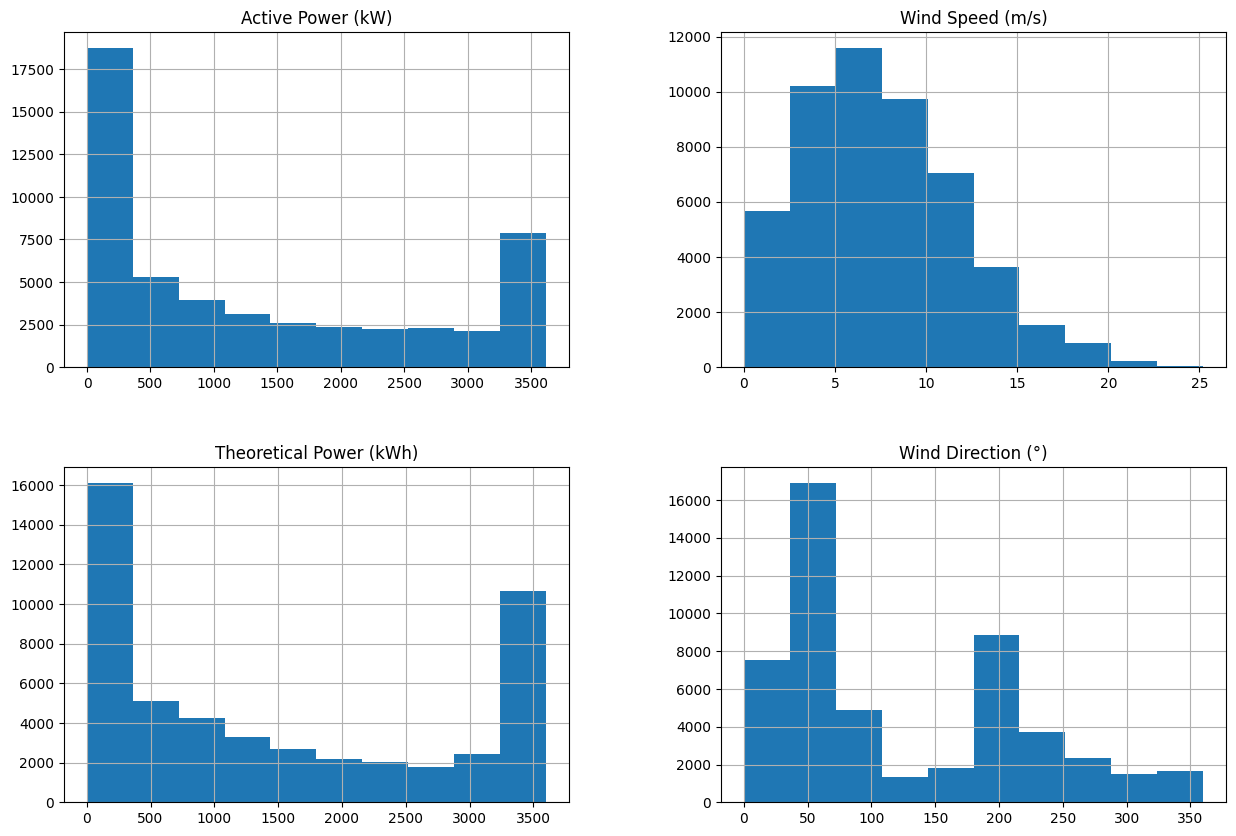

In [10]:
# Histogramas de frequências
dataset.hist(figsize = (15,10))
plt.show()

A partir dos histogramas, vemos que os atributos "Active Power", "Wind Direction" e "Theoretical Power" seguem uma distribuição bimodal aproximada, enquanto que a "Wind Speed" segue uma distribuição aproximadamente normal.

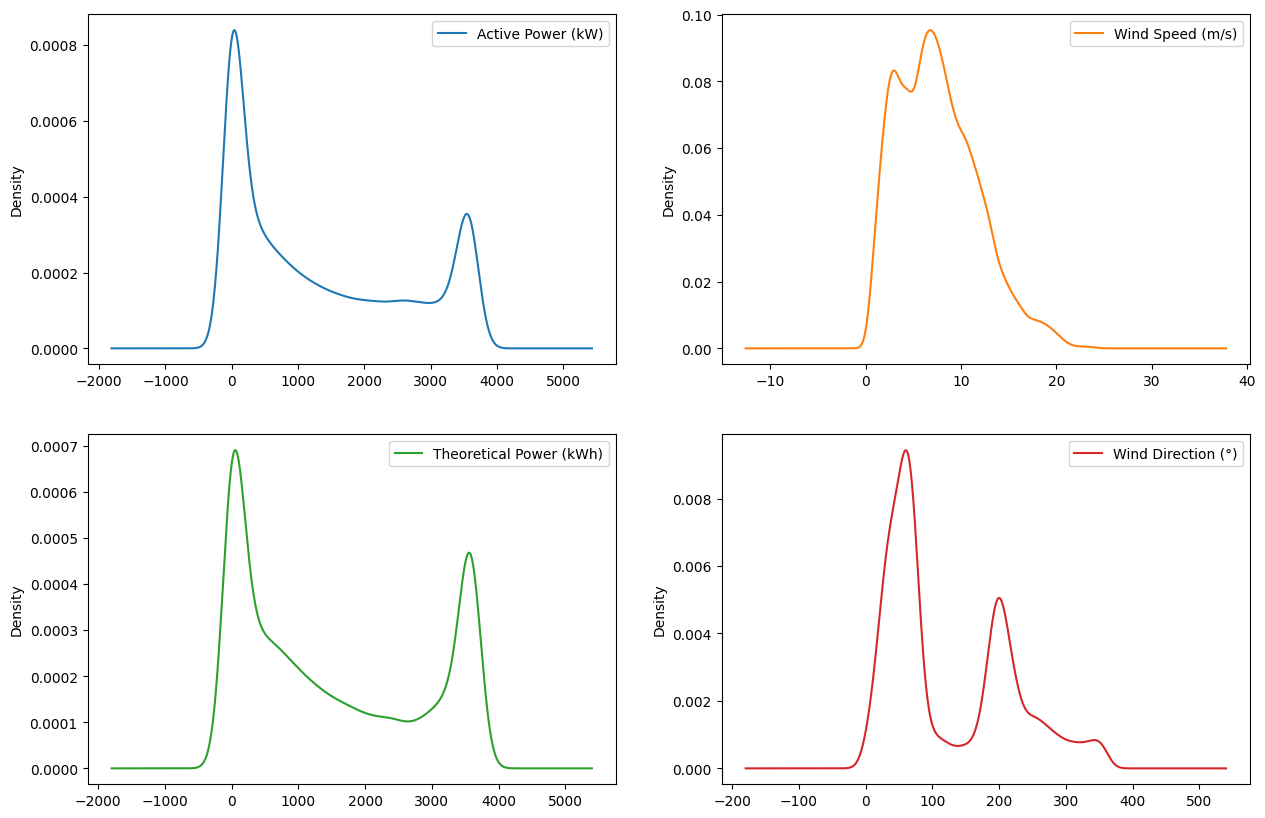

In [11]:
# Density Plot
dataset.plot(kind = 'density', subplots = True, layout = (2,2), sharex = False, figsize = (15,10))
plt.show()

O **gráfico de densidade**, ou **density plot**, é bem parecido com o histograma, mas com uma visualização um pouco diferente. Com ele, pode ser mais fácil identificar a distribuição do atributos do dataset. Assim como fizemos com o histograma, criamos um density plot para cada atributo do dataset. Vemos que muitos dos atributos têm uma distribuição distorcida.

Tanto o histograma quanto o density plot do atributo "Active Power" mostram que há uma grande concentração de dados próximos de zero. Esses valores serão tratados como *outliers*, pois podem introduzir no modelo um comportamento anômalo, condições de operação especial que podem não ser representativas do comportamento normal do sistema, conforme explicado na seção de Definição do Problema.

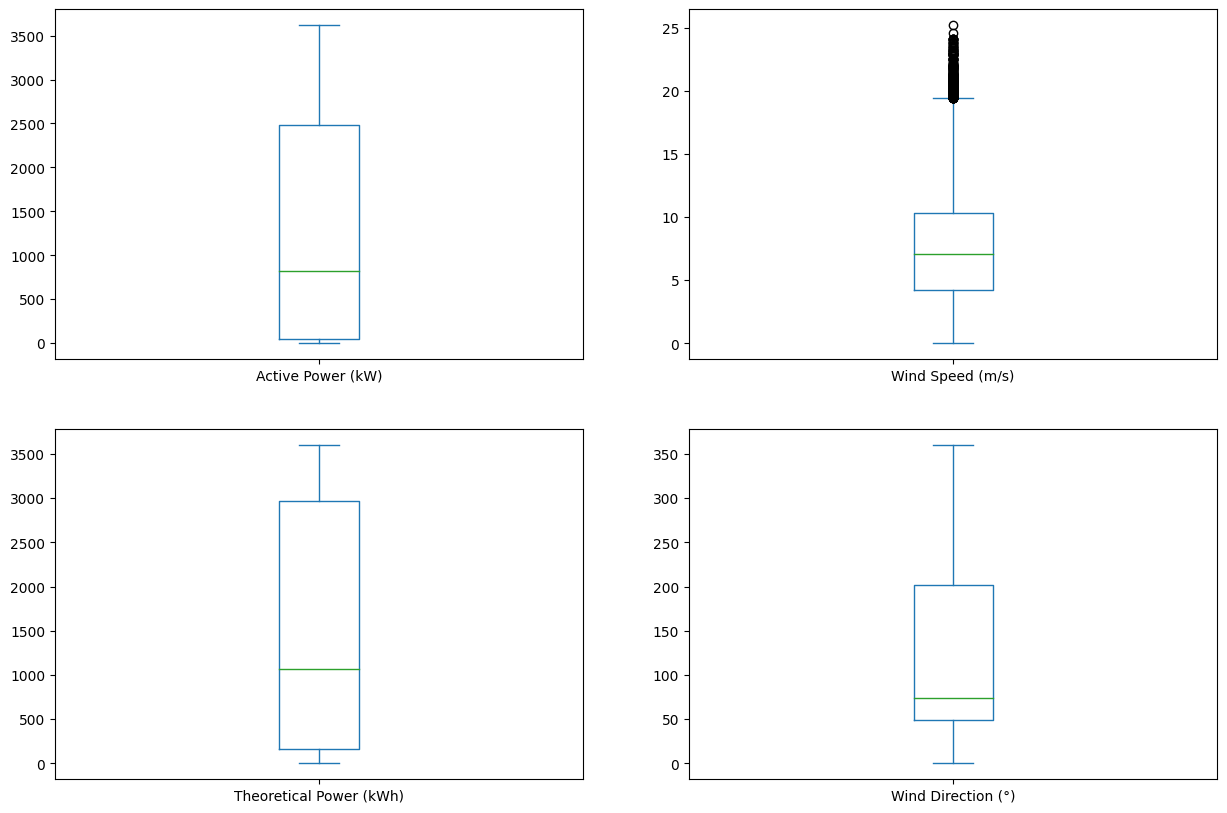

In [12]:
# Boxplot
dataset.plot(kind = 'box', subplots = True, layout = (2,2), sharex = False, sharey = False, figsize = (15,10))
plt.show()

No boxblot, a linha no centro (verde) representa o valor da mediana (segundo quartil ou p50). A linha abaixo é o 1o quartil (p25) e a linha acima o terceiro quartil (p75). O boxplot ajuda a ter uma ideia da dispersão dos dataset e os possíveis outliers.

Analisando os gráficos bloxplot, percebemos que a dispersão dos atributos do dataset é bem diferente. Para o caso da "Wind Speed", há pontos fora das linhas horizontais (>20 m/s) que, em teoria, seriam considerados *outliers*. Porém, há épocas do ano onde velocidades de vento elevadas são esperadas e não são anômalas. O futuro modelo deve ser capaz de prever esse contexto e, por essa razão, uma parte desses dados deve ser mantida. Isso será feito na seção de Tratamento de Outliers.

## 2.5. Visualizações Multimodais

A **matriz de correlação** a seguir exibe graficamente a correlação entre os atributos numéricos do dataset.

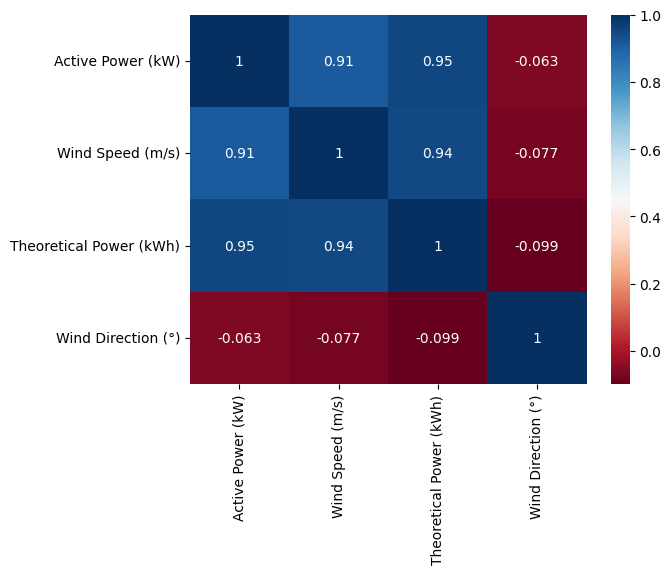

In [13]:
# Matriz de Correlação com Matplotlib Seaborn
sns.heatmap(dataset.corr(), annot=True, cmap='RdBu');

Ao visualizar as correlações entre os atributos através da matriz de correlação, percebemos que há uma estrutura na ordem dos atributos.

Existem várias formas de calcular a correlação entre duas variáveis, como por exemplo, o coeficiente de correlação de Pearson, que pode ser:
* Próximo de -1 : há uma correlação negativa entre as variáveis,
* Próximo de +1: há uma correlação positiva entre as variáveis.
* 0: não há correlação entre as variáveis.

Nesse contexto, todos os atributos são altamente correlacionados entre si, de acordo com os coeficientes de correlação de Pearson (todos acima de 0.9). A única excessão é a direção do vento (Wind Direction), que possui uma baixíssima correlação negativa com os demais atributos. Como os valores dos coeficientes de correlação são muito baixos, essa correlação pode ser considerada inexistente.

Esta informação sobre a correlação entre os atributos é relevante porque alguns algoritmos como regressão linear e regressão logística podem apresentar problemas de performance se houver atributos altamente correlacionados. Vale a pena consultar a documentação do algoritmo para verificar se algum tipo de tratamento de dataset é necessário.

Por sua vez, o gráfico de dispersão (**scatter plot**) mostra o relacionamento entre duas variáveis. Vamos exibir um para cada par de atributos dos dataset, usando o Seaborn.

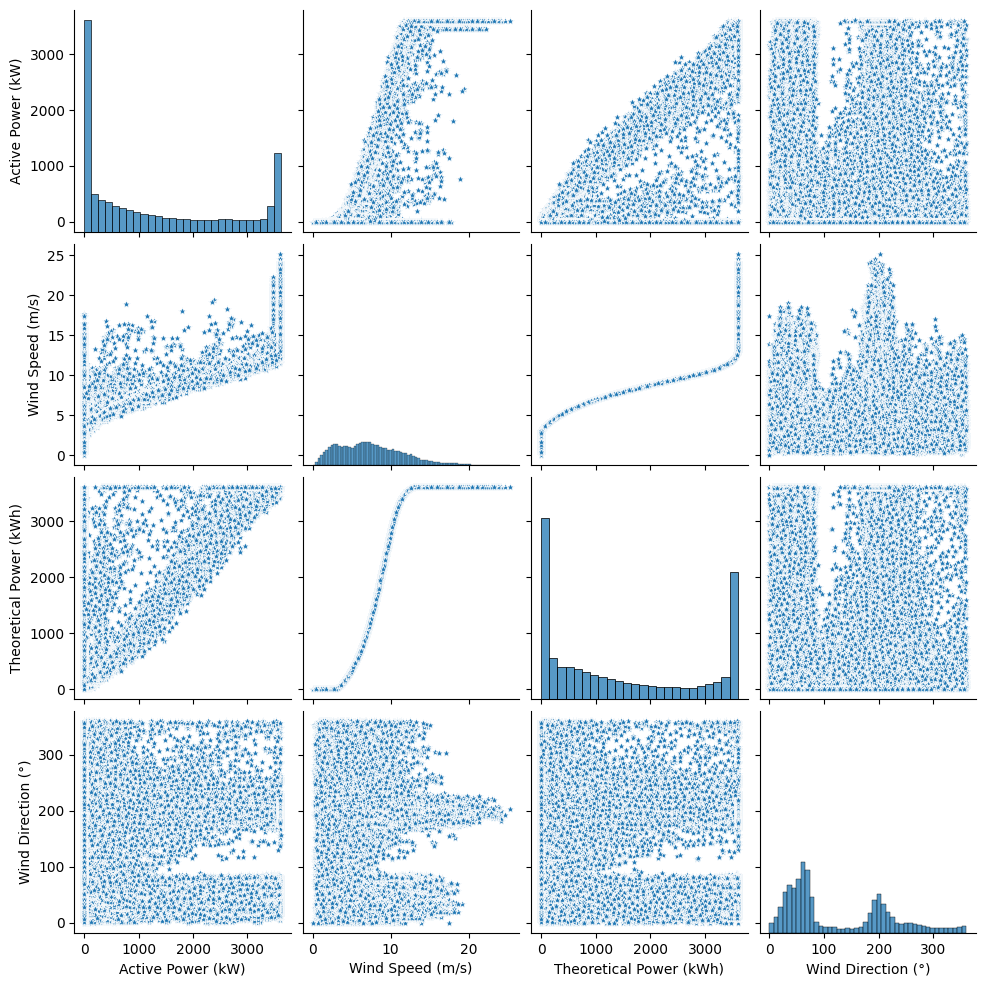

In [14]:
# Scatter Plot com Seaborn
sns.pairplot(dataset, markers='*')

Nesse scatter plot, os gráficos diagonais fornecem histogramas da distribuição de probabilidade univariadas para cada variável. Esses histogramas mostram como os valores de cada variável estão distribuídos.

Fora da diagonal principal, cada célula contém um gráfico de dispersão que representa a relação entre duas variáveis. Isso ajuda a visualizar a correlação ou dependência entre pares de variáveis. Nesse contexto, destacamos que os atributos "Active Power" e "Theoretical Power" possuem uma distribuição triangular acima e abaixo da diagonal principal, o que sugere uma relação linear entre as variáveis.

Nessa altura, também podemos visualizar as curvas de potência do aerogerador (Active Power x Wind Speed e Theoretical Power x Wind Speed). Para uma comparação mais efetiva, vamos plotar essa curva separadamente a seguir.

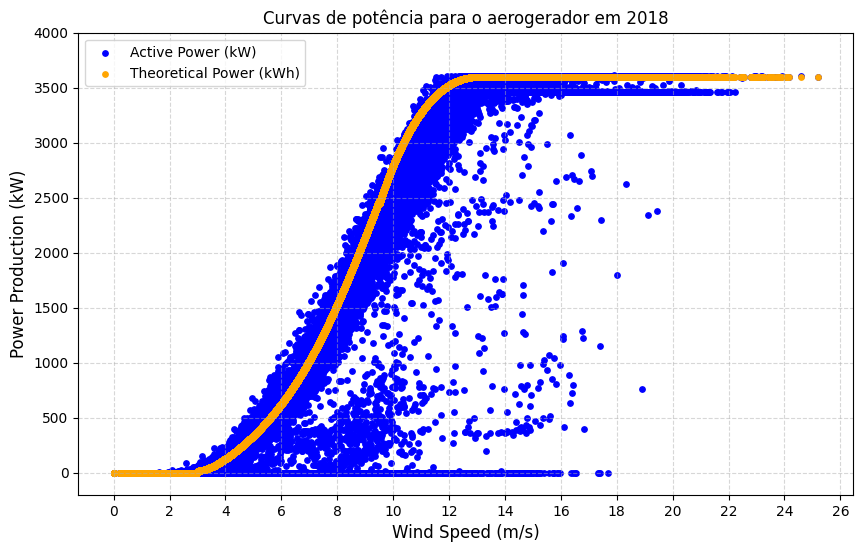

In [15]:
# Plotar curvas de potência para o aerogerador

# Preparar a figura
plt.figure(figsize=(10, 6))

# Potência ativa
plt.scatter(dataset['Wind Speed (m/s)'], dataset['Active Power (kW)'], label='Active Power (kW)', color='blue', marker="o", s=15)

# Potência teórica
plt.scatter(dataset['Wind Speed (m/s)'], dataset['Theoretical Power (kWh)'], label='Theoretical Power (kWh)', color='orange', marker="o", s=15)

# Exibir legenda
plt.legend()

# Nomenclatura dos eixos x e y
plt.xlabel('Wind Speed (m/s)', fontsize=12)
plt.ylabel('Power Production (kW)', fontsize=12)
plt.title('Curvas de potência para o aerogerador em 2018')

# Definir explicitamente os limites do eixo x
xmin = 0  # Especificar o limite inferior
xmax = 26  # Especificar o superior
x_step = 2  # Especificar o passo
plt.xticks(np.arange(xmin, xmax+1, x_step), fontsize=10) # Definir passo e tamanho de fonte dos ticks do eixo x

# Definir limites e o passo no eixo y
ymin = 0  # Especificar o limite inferior
ymax = 4000  # Especificar o superior
y_step = 500  # Especificar o passo
plt.yticks(np.arange(ymin, ymax+1, y_step), fontsize=10) # Definir passo e tamanho de fonte dos ticks do eixo y
plt.ylim(ymin-200, ymax)

# Adicionar grids no gráfico
plt.grid(True, linestyle='--', alpha=0.5)

# Exibir o gráfico
plt.show()

Analisando as curvas de potência, podemos perceber que a potência ativa (Active Power) possui uma grande quantidade de valores *outliers* em relação à potência teórica (Theoretical Power). Isso será tratado na seção de Tratamento dos Outliers.

# 3. Pré-Processamento de dados

Nesta etapa, poderíamos realizar diversas operações de preparação de dados, como por exemplo, tratamento de valores *missings*, limpeza de dados, transformações, seleção de características (feature selection).

## 3.1. Manipulação inicial do dataset

Essa manipulação inicial do dataset será útil para viabilizar operações relacionadas a datas e horas, como extrair componentes de data (ano, mês, dia, etc.), realizar cálculos com datas, entre outras operações específicas para dados temporais.

In [16]:
# Fazer cópia de segurança do dataset original
datasetTemporal = dataset.copy()

In [17]:
# Converter 'Date/Time' para datetime
datasetTemporal['Date/Time'] = pd.to_datetime(datasetTemporal['Date/Time'])

# Criar a coluna 'Month' diretamente no formato de período
datasetTemporal['Month'] = datasetTemporal['Date/Time'].dt.to_period('M')

# Converter 'Month' novamente para datetime
datasetTemporal['Month'] = datasetTemporal['Month'].dt.to_timestamp()

# Inserir a coluna 'Month' após 'Date/Time'
datasetTemporal.insert(1, 'Month', datasetTemporal.pop('Month'))

In [18]:
print(datasetTemporal)

                Date/Time      Month  Active Power (kW)  Wind Speed (m/s)  \
0     2018-01-01 00:00:00 2018-01-01         380.047791          5.311336   
1     2018-01-01 00:10:00 2018-01-01         453.769196          5.672167   
2     2018-01-01 00:20:00 2018-01-01         306.376587          5.216037   
3     2018-01-01 00:30:00 2018-01-01         419.645905          5.659674   
4     2018-01-01 00:40:00 2018-01-01         380.650696          5.577941   
...                   ...        ...                ...               ...   
50525 2018-12-31 23:10:00 2018-12-01        2963.980957         11.404030   
50526 2018-12-31 23:20:00 2018-12-01        1684.353027          7.332648   
50527 2018-12-31 23:30:00 2018-12-01        2201.106934          8.435358   
50528 2018-12-31 23:40:00 2018-12-01        2515.694092          9.421366   
50529 2018-12-31 23:50:00 2018-12-01        2820.466064          9.979332   

       Theoretical Power (kWh)  Wind Direction (°)  
0                   41

Agora criaremos um resumo estatístico mensal com o objetivo de analisar as médias e medianas. Para ilustrar essa comparação, na sequência também faremos os gráficos de linha.

In [19]:
# Agrupar os dados por mês e realize a agregação necessária (por exemplo, média, soma, etc.)
resumoMensal = datasetTemporal.groupby('Month').agg({'Active Power (kW)': ['mean', 'median'],
                                              'Wind Speed (m/s)': ['mean', 'median'],
                                              'Theoretical Power (kWh)': ['mean', 'median'],
                                              'Wind Direction (°)': ['mean', 'median']}).reset_index()

# Exiba o DataFrame resultante
print(resumoMensal)

        Month Active Power (kW)              Wind Speed (m/s)            \
                           mean       median             mean    median   
0  2018-01-01       1469.538834   930.772888         9.407847  9.049827   
1  2018-02-01       1398.812191  1022.821991         8.179499  7.863296   
2  2018-03-01       1778.547254  1582.933960         9.204149  8.434291   
3  2018-04-01       1062.471714   473.491699         6.740089  5.879722   
4  2018-05-01       1099.212305   675.612213         6.693869  6.633387   
5  2018-06-01       1168.209523   768.023315         6.844458  6.763925   
6  2018-07-01        694.432261   226.971794         5.474675  4.804646   
7  2018-08-01       1510.816574  1180.406494         8.050320  7.703878   
8  2018-09-01       1491.921321  1016.616028         7.704346  7.300117   
9  2018-10-01       1178.213240   832.783264         6.859317  6.778285   
10 2018-11-01       1745.561611  1558.900024         8.871619  8.265819   
11 2018-12-01       1189.

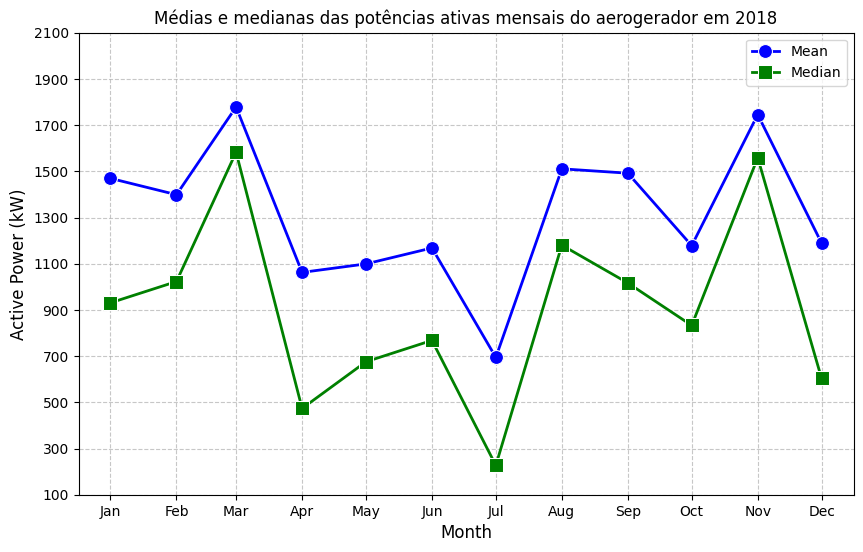

In [20]:
# Plotar o gráfico de linha usando seaborn da média mensal e mediana da potência ativa do aerogerador no ano de 2018
plt.figure(figsize=(10, 6))

# Linha da média
sns.lineplot(data=resumoMensal, x='Month', y=('Active Power (kW)', 'mean'), label='Mean', color='blue', marker="o", linewidth=2, markersize=10)

# Linha da mediana
sns.lineplot(data=resumoMensal, x='Month', y=('Active Power (kW)', 'median'), label='Median', color='green', marker="s", linewidth=2, markersize=10)

# Nomenclatura dos eixos x e y
plt.xlabel('Month', fontsize=12)
plt.ylabel('Active Power (kW)', fontsize=12)
plt.title('Médias e medianas das potências ativas mensais do aerogerador em 2018')

# Definir explicitamente os limites do eixo x
xmin = resumoMensal['Month'].min() - pd.to_timedelta('15 days')  # Subtrai 15 dias do mínimo
xmax = resumoMensal['Month'].max() + pd.to_timedelta('15 days')  # Adiciona 15 dias ao máximo
plt.xlim(xmin, xmax)
plt.xticks(fontsize=10) # Definir tamanho de fonte dos ticks do eixo x

# Definir limites e o passo no eixo y
ymin = 100  # Especificar o limite inferior
ymax = 2100  # Especificar o superior
y_step = 200  # Especificar o passo
plt.yticks(np.arange(ymin, ymax+1, y_step), fontsize=10) # Definir passo e tamanho de fonte dos ticks do eixo y
plt.ylim(ymin, ymax)

# Ajustar o formato do eixo x para exibir os nomes para cada mês do ano
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))

# Adicionar grids no gráfico
plt.grid(True, linestyle='--', alpha=0.7)

# Exibir o gráfico
plt.show()

Através do gráfico, vemos que a potência ativa média é maior do que a sua mediana em todos os meses no ano de 2018.

A média é mais sensível a valores extremos do que a mediana. Portanto, apenas alguns valores de dados excepcionalmente altos terão um impacto mais significativo na média do que na mediana. É provável que haja picos de produção de energia em semanas ou dias específicos todos os meses e que isso esteja aumentando o valor médio da potência produzida.

## 3.2. Verificação e Tratamento de Missings

Faremos agora a verificação de possíveis missings.



In [21]:
# Verificar nulls no dataset
datasetTemporal.isnull().sum()

Date/Time                  0
Month                      0
Active Power (kW)          0
Wind Speed (m/s)           0
Theoretical Power (kWh)    0
Wind Direction (°)         0
dtype: int64

<Axes: >

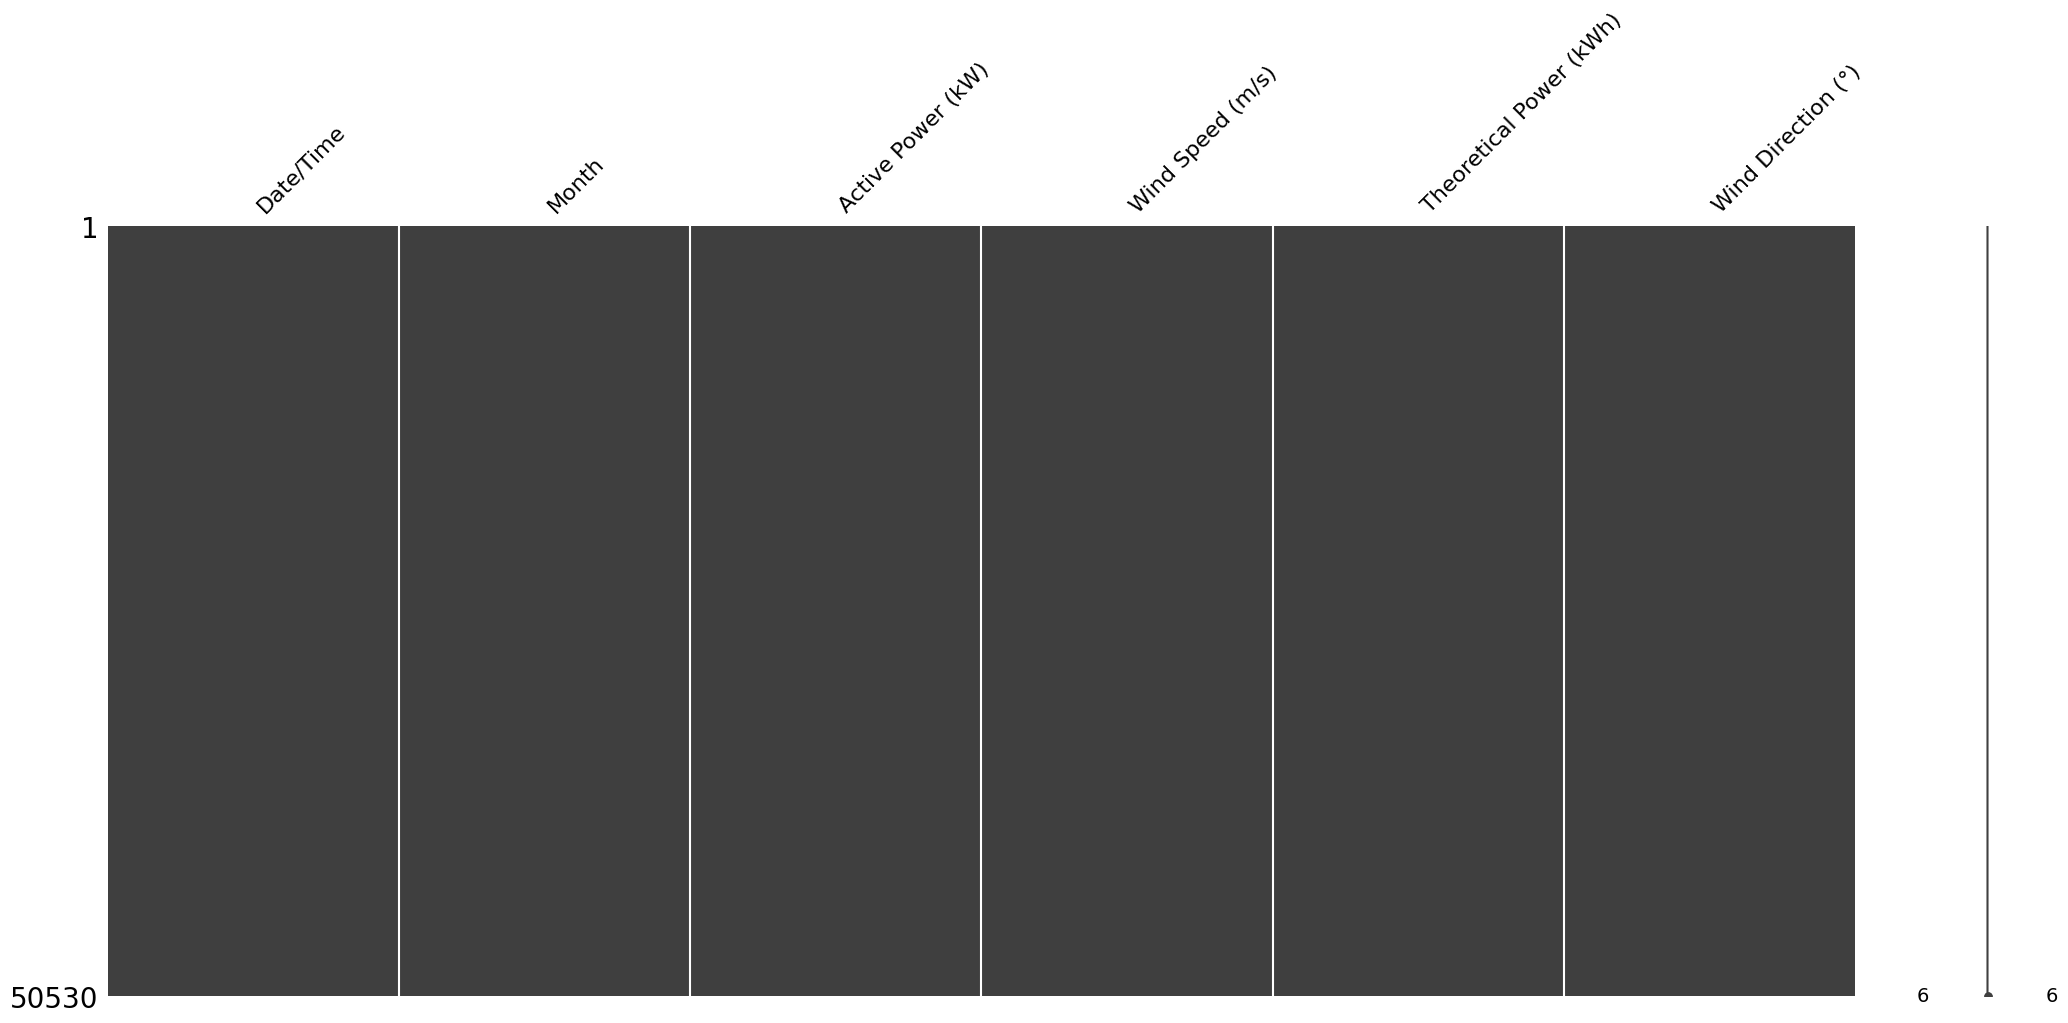

In [22]:
# Exibir visualização matricial da nulidade do dataset
ms.matrix(datasetTemporal)

Visualizamos, a partir da matrix e dos *nulls*, que o dataset não tem *missings* aparentes.




## 3.3. Tratamento dos Outliers

As três fontes de valores *outliers* consideradas nesse projeto serão as seguintes:

**1. Valores de potência ativa negativos ou próximos de zero:**

 * Descrição: os valores da potência tendem a zero quando a velocidade do vento está acima da velocidade de corte (cut-in) e abaixo da velocidade de desligamento (cut-out).

 * Possíveis causas: manutenção da turbina eólica e limitação de vento.

**2. Valores distantes da curva de potência teórica:**

* Descrição: os valores de potência ativa estão significativamente afastadas dos valores esperados, conforme representados pela curva de potência teórica, mas não são iguais a zero.

* Possíveis causas: limitação de vento, sujeira nas pás, insetos ou gelo, mau funcionamento do controle de inclinação, entre outros fatores.

**3. Valores que excedem a limitação física do equipamento:**

* Descrição: A potência do vento atinge valores que ultrapassam a limitação física da turbina eólica.

* Possíveis causas: condições operacionais extremas.

Esses três tipos de valores *outliers* são analisados para compreender as características que podem introduzir erros na modelagem da curva de potência. Por essa razão, é fundamental identificar e remover esses outliers dos dados brutos antes de utilizá-los para treinar futuros modelos.

In [23]:
# Criar uma cópia de segurança do dataset antes das manipulações
datasetCopiaSegura = datasetTemporal.copy()

Faremos agora a divisão do dataset em subconjuntos com base nos valores de 'ActivePower (kW)'. Em seguida, removeremos os *outliers* em cada subconjunto e concatenaremos os subconjuntos tratados para criar um novo dataset sem *outliers*. Esse processo será realizado de forma dinâmica, ajustando os critérios de remoção de *outliers* com base nos intervalos específicos dos valores de 'ActivePower (kW)'.







In [24]:
# Função para remover outliers
def remover_outliers(df, coluna, percentil_min, percentil_max):
    """
    Essa função remove os outliers de um coluna específica do dataset,
    utilizando percentis mínimo e máximo.
    """
    # Calcula os quartis para os percentis mínimos e máximos
    q_baixo = df[coluna].quantile(percentil_min)
    q_alto = df[coluna].quantile(percentil_max)

    # Filtra o DataFrame mantendo apenas os valores dentro do intervalo definido pelos quartis
    return df[(df[coluna] < q_alto) & (df[coluna] > q_baixo)]

In [25]:
# Função para criar subconjuntos de dados
def criar_subconjuntos_de_dados(data, passo=50, limite_superior=3400):
    """
    Essa função divide o dataset em subconjuntos com base nos valores da
    coluna 'ActivePower (kW)'. Cada subconjunto abrange um intervalo
    específico (definidos pelo passo) e armazena o subconjunto num
    dicionário. Cada subconjunto é representado por um intervalo inferior
    e o último subconjunto inclui valores maiores ou iguais a 3300.
    """
    subconjuntos = {}
    for limite_inferior in range(20, limite_superior, passo):
        limite_superior_atual = limite_inferior + passo
        # Condição para criar o subconjunto baseado nos limites
        condicao = (data['Active Power (kW)'] >= limite_inferior) & (data['Active Power (kW)'] < limite_superior_atual)
        subconjuntos[limite_inferior] = data[condicao]

    # Adiciona o último subconjunto para valores >= 3300
    subconjuntos[limite_superior] = data[data['Active Power (kW)'] >= 3300]

    return subconjuntos

In [26]:
# Criar subconjuntos de dados
subconjuntos_de_dados = criar_subconjuntos_de_dados(datasetCopiaSegura)

# Remoção de outliers para cada subconjunto de dados
for limite_inferior, df in subconjuntos_de_dados.items():
    if limite_inferior <= 3:
        F = 0.95
    elif 3 < limite_inferior <= 10:
        F = 0.90
    elif 10 < limite_inferior <= 20:
        F = 0.92
    elif 20 < limite_inferior < 30:
        F = 0.96
    else:
        F = 0.985

    subconjuntos_de_dados[limite_inferior] = remover_outliers(df, 'Wind Speed (m/s)', 0.0001, F)

# Concatenação dos subconjuntos de dados em um único dataset
datasetFiltrado = pd.concat(subconjuntos_de_dados.values(), ignore_index=True)

O trecho de código acima realiza o procedimento de remoção dos *outliers*. Os valores de '0.0001' e de 'F' foram ajustados até que a curva de potência plotada abaixo apresentasse uma menor dispersão nos valores de potência gerada (ativa) em relação aos valores esperados (potência teórica).

In [27]:
# Mostrar as dimensões do dataset filtrado sem outliers
instancias, atributos = datasetFiltrado.shape
print(f'O dataset filtrado sem outliers possui {instancias} instâncias e {atributos} atributos')

O dataset filtrado sem outliers possui 38839 instâncias e 6 atributos


O dataset original (com *outliers*) possuía um número de instâncias 50530. Vamos plotar a nova curva de potências para anilisar melhor o efeito dessa manipulação.

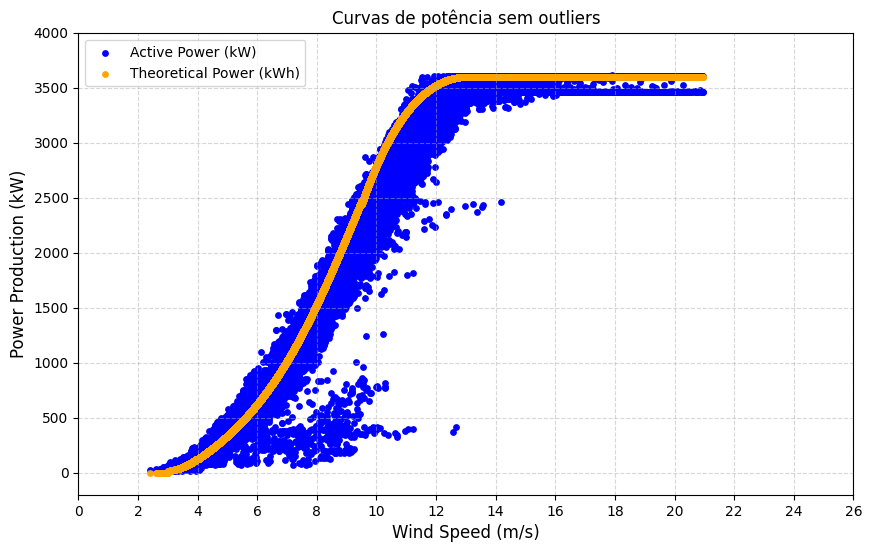

In [28]:
# Plotar curvas de potência para o aerogerador

# Preparar a figura
plt.figure(figsize=(10, 6))

# Potência ativa
plt.scatter(datasetFiltrado['Wind Speed (m/s)'], datasetFiltrado['Active Power (kW)'],
            label='Active Power (kW)', color='blue', marker="o", s=15)

# Potência teórica
plt.scatter(datasetFiltrado['Wind Speed (m/s)'], datasetFiltrado['Theoretical Power (kWh)'],
            label='Theoretical Power (kWh)', color='orange', marker="o", s=15)

# Exibir legenda
plt.legend()

# Nomenclatura dos eixos x e y
plt.xlabel('Wind Speed (m/s)', fontsize=12)
plt.ylabel('Power Production (kW)', fontsize=12)
plt.title('Curvas de potência sem outliers')

# Definir explicitamente os limites do eixo x
xmin = 0  # Especificar o limite inferior
xmax = 26  # Especificar o superior
x_step = 2  # Especificar o passo
plt.xticks(np.arange(xmin, xmax+1, x_step), fontsize=10) # Definir passo e tamanho de fonte dos ticks do eixo x

# Definir limites e o passo no eixo y
ymin = 0  # Especificar o limite inferior
ymax = 4000  # Especificar o superior
y_step = 500  # Especificar o passo
plt.yticks(np.arange(ymin, ymax+1, y_step), fontsize=10) # Definir passo e tamanho de fonte dos ticks do eixo y
plt.ylim(ymin-200, ymax)

# Adicionar grids no gráfico
plt.grid(True, linestyle='--', alpha=0.5)

# Exibir o gráfico
plt.show()

Através da curva de potência sem *outliers*, podemos notar que os valores de potência ativa (gerada) que não foram filtrados na manipulação do dataset estão bem mais próximos dos valores de potência teórica.

## 3.4. Influência da Remoção dos Outliers nos Dados

Para analisar a nova distribuição dos dados após a remoção dos *outliers*, vamos plotar histogramas sobrepostos de distribuição de frequências.

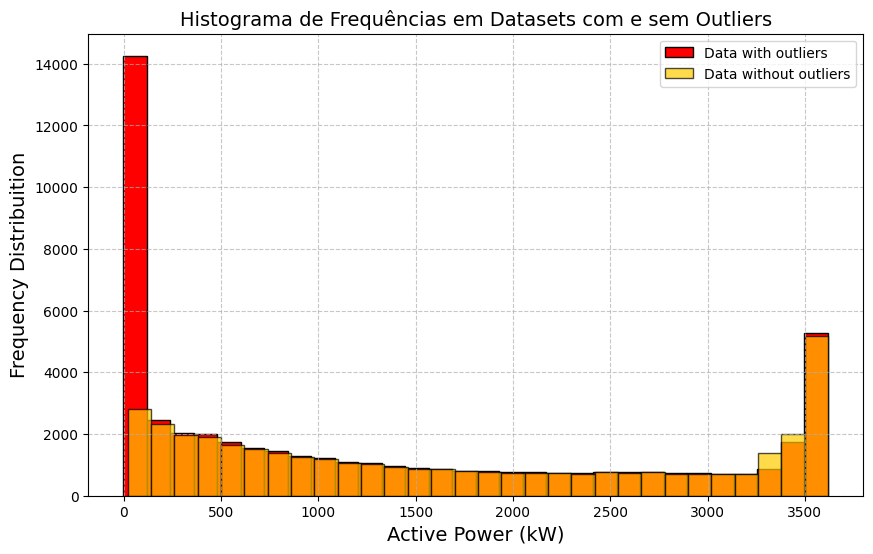

In [29]:
# Configurar o tamanho da figura
plt.figure(figsize=(10, 6))

# Plotar histograma para dataset com outliers
plt.hist(datasetTemporal['Active Power (kW)'], bins=30, color='red', alpha=1,
         label='Data with outliers', edgecolor='black')

# Plotar histograma para dataset sem outliers
plt.hist(datasetFiltrado['Active Power (kW)'], bins=30, color='#fc0', alpha=0.7,
         label='Data without outliers', edgecolor='black')

# Adicionar rótulos e título
plt.xlabel('Active Power (kW)', fontsize=14)
plt.ylabel('Frequency Distribuition', fontsize=14)
plt.title('Histograma de Frequências em Datasets com e sem Outliers', fontsize=14)
plt.legend()

# Adicionar grades (grid)
plt.grid(True, linestyle='--', alpha=0.7)

# Exibir o histograma
plt.show()

A região laranja do gráfico sinaliza a interseção entre os histogramas dos datasets com outliers (barra vermelha) e sem outliers (barra amarela). Vemos que há uma redução considerável da frequência de *outliers* de baixos valores, pois estes foram removidos do dataset, fazendo com que os dados ficassem menos dispersos.

Agora faremos um resumo estatístico para o dataset filtrado para entendermos qual foi o impacto dessa manipulação nos dados estatísticos. Para isso, precisamos agrupar os dados mensais para o novo dataset.

In [30]:
# Agrupar os dados por mês e realize a agregação necessária (por exemplo, média, soma, etc.)
resumoMensalSemOutliers = datasetFiltrado.groupby('Month').agg({'Active Power (kW)': ['mean', 'median'],
                                              'Wind Speed (m/s)': ['mean', 'median'],
                                              'Theoretical Power (kWh)': ['mean', 'median'],
                                              'Wind Direction (°)': ['mean', 'median']}).reset_index()

# Exiba o DataFrame resultante
print(resumoMensalSemOutliers)

        Month Active Power (kW)              Wind Speed (m/s)             \
                           mean       median             mean     median   
0  2018-01-01       2240.123344  2685.001953        10.613395  10.500000   
1  2018-02-01       1962.109659  1868.247009         9.617629   8.802019   
2  2018-03-01       2100.989429  2245.472900        10.177998   9.471620   
3  2018-04-01       1505.571090   932.308411         8.307097   7.035699   
4  2018-05-01       1513.878763  1278.436035         8.046906   7.812349   
5  2018-06-01       1579.812385  1476.828003         8.392667   8.213219   
6  2018-07-01       1065.230510   620.226074         7.080731   6.272809   
7  2018-08-01       1688.471415  1425.410034         8.637845   8.146570   
8  2018-09-01       1849.523624  1802.390991         8.878219   8.754924   
9  2018-10-01       1512.606580  1236.426453         8.124234   7.677040   
10 2018-11-01       2081.722569  2199.184937        10.003265   9.416845   
11 2018-12-0

Agora plotaremos os gráficos de linha, respectivamente, para as médias e medianas mensais para o dataset antes e depois da filtragem dos *outliers*.

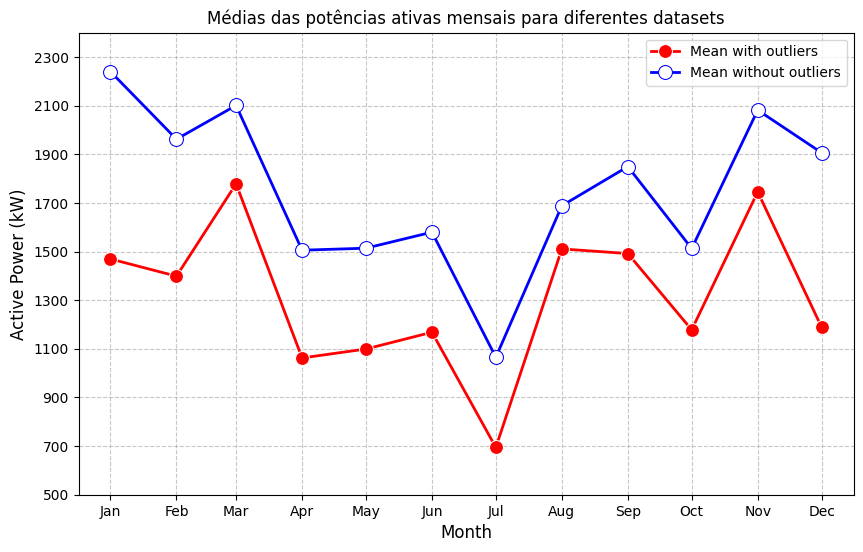

In [31]:
# Plotar o gráfico de linha usando seaborn das médias mensais da potência ativa do aerogerador no ano de 2018
# Comparação entre o dataset original e o dataset sem outliers
plt.figure(figsize=(10, 6))

# Linha da média no dataset original
sns.lineplot(data=resumoMensal, x='Month', y=('Active Power (kW)', 'mean'),
             label='Mean with outliers', color='red', marker="o", linewidth=2, markersize=10)

# Linha da média no dataset sem outliers
sns.lineplot(data=resumoMensalSemOutliers, x='Month', y=('Active Power (kW)', 'mean'),
             label='Mean without outliers', color='blue', marker="o",
             markeredgecolor='blue', markerfacecolor='white', linewidth=2, markersize=10)

# Nomenclatura dos eixos x e y
plt.xlabel('Month', fontsize=12)
plt.ylabel('Active Power (kW)', fontsize=12)
plt.title('Médias das potências ativas mensais para diferentes datasets')

# Definir explicitamente os limites do eixo x
xmin = resumoMensal['Month'].min() - pd.to_timedelta('15 days')  # Subtrai 15 dias do mínimo
xmax = resumoMensal['Month'].max() + pd.to_timedelta('15 days')  # Adiciona 15 dias ao máximo
plt.xlim(xmin, xmax)
plt.xticks(fontsize=10) # Definir tamanho de fonte dos ticks do eixo x

# Definir limites e o passo no eixo y
ymin = 500  # Especificar o limite inferior
ymax = 2400  # Especificar o superior
y_step = 200  # Especificar o passo
plt.yticks(np.arange(ymin, ymax+1, y_step), fontsize=10) # Definir passo e tamanho de fonte dos ticks do eixo y
plt.ylim(ymin, ymax)

# Ajustar o formato do eixo x para exibir os nomes para cada mês do ano
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))

# Adicionar grids no gráfico
plt.grid(True, linestyle='--', alpha=0.7)

# Exibir o gráfico
plt.show()

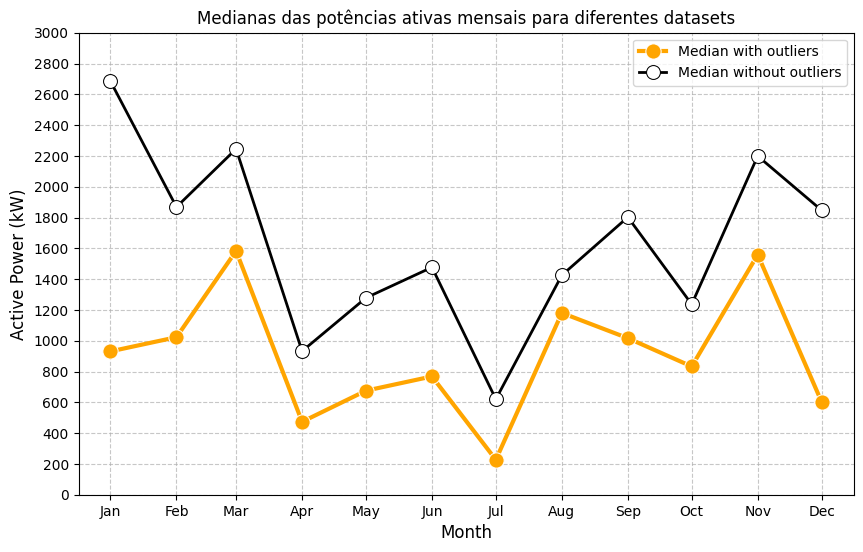

In [32]:
# Plotar o gráfico de linha usando seaborn das medianas mensais da potência ativa do aerogerador no ano de 2018
# Comparação entre o dataset original e o dataset sem outliers
plt.figure(figsize=(10, 6))

# Linha da mediana no dataset original
sns.lineplot(data=resumoMensal, x='Month', y=('Active Power (kW)', 'median'),
             label='Median with outliers', color='orange', marker="o", linewidth=3, markersize=11)

# Linha da mediana no dataset sem outliers
sns.lineplot(data=resumoMensalSemOutliers, x='Month', y=('Active Power (kW)', 'median'),
             label='Median without outliers', color='black', marker="o",
             markeredgecolor='black', markerfacecolor='white', linewidth=2, markersize=10)

# Nomenclatura dos eixos x e y
plt.xlabel('Month', fontsize=12)
plt.ylabel('Active Power (kW)', fontsize=12)
plt.title('Medianas das potências ativas mensais para diferentes datasets')

# Definir explicitamente os limites do eixo x
xmin = resumoMensal['Month'].min() - pd.to_timedelta('15 days')  # Subtrai 15 dias do mínimo
xmax = resumoMensal['Month'].max() + pd.to_timedelta('15 days')  # Adiciona 15 dias ao máximo
plt.xlim(xmin, xmax)
plt.xticks(fontsize=10) # Definir tamanho de fonte dos ticks do eixo x

# Definir limites e o passo no eixo y
ymin = 0 # Especificar o limite inferior
ymax = 3000  # Especificar o superior
y_step = 200  # Especificar o passo
plt.yticks(np.arange(ymin, ymax+1, y_step), fontsize=10) # Definir passo e tamanho de fonte dos ticks do eixo y
plt.ylim(ymin, ymax)

# Ajustar o formato do eixo x para exibir os nomes para cada mês do ano
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))

# Adicionar grids no gráfico
plt.grid(True, linestyle='--', alpha=0.7)

# Exibir o gráfico
plt.show()

De acordo com os gráficos das médias e medianas mensais, podemos notar que ambas as variáveis aumentaram em todos os meses para o dataset sem os *outliers*. Isso é uma indicação de que havia uma distribuição razoavelmente uniforme dos *outliers* ao longo do ano.

As médias mensais pós tratamento dos *outliers* mantiveram, ao longo do ano, um padrão similar ao dos dados não tratados. Para as medianas, a única excessão foi o mês de Janeiro, o que sugere uma quantidade maior de *outliers* nesse mês.

Na comparação mês a mês, antes e após o tratamento dos *outliers*, Janeiro e Dezembro apresentaram as maiores diferenças tanto para as médias, quanto para as medianas. Isso indica que esses meses possuem mais *outliers* do que os demais, o que provavelmente pode ter relação com condições meteorológicas específicas nessa época do ano.

Para ter uma visão global da influência da remoção dos *outliers* em outras medidas estatísticas, vamos produzir 2 novos datasets, antes e depois da manipulação, com os seguintes dados:

* Média
* Desvio padrão
* Percentil 25
* Percentil 50 (mediana)
* Percentil 75


Vamos criar datasets, antes e após a remoção dos outliers, respectivamente, com o resumo das principais medidas estatísticas.

In [33]:
# Reunir dados estatísticos antes do tratamento dos outliers
estatisticas = {
    'mean': datasetTemporal['Active Power (kW)'].mean(),
    'std': datasetTemporal['Active Power (kW)'].std(),
    '25th percentile': datasetTemporal['Active Power (kW)'].quantile(0.25),
    'median': datasetTemporal['Active Power (kW)'].median(),
    '75th percentile': datasetTemporal['Active Power (kW)'].quantile(0.75),
}

# Criar DataFrame
resumo_estatistico = pd.DataFrame(estatisticas, index=['Active Power (kW)'])

# Transpor o DataFrame para que as estatísticas se tornem colunas
resumo_estatistico = resumo_estatistico.T

# Exibir o novo DataFrame
print(resumo_estatistico)


                 Active Power (kW)
mean                   1307.684332
std                    1312.459242
25th percentile          50.677890
median                  825.838074
75th percentile        2482.507568


In [34]:
# Reunir dados estatísticos sem outliers (so)
estatisticas = {
    'mean': datasetFiltrado['Active Power (kW)'].mean(),
    'std': datasetFiltrado['Active Power (kW)'].std(),
    '25th percentile': datasetFiltrado['Active Power (kW)'].quantile(0.25),
    'median': datasetFiltrado['Active Power (kW)'].median(),
    '75th percentile': datasetFiltrado['Active Power (kW)'].quantile(0.75),
}

# Criar DataFrame
resumo_estatistico_so = pd.DataFrame(estatisticas, index=['Active Power (kW)'])

# Transpor o DataFrame para que as estatísticas se tornem colunas
resumo_estatistico_so = resumo_estatistico_so.T

# Exibir o novo DataFrame
print(resumo_estatistico_so)

                 Active Power (kW)
mean                   1744.570823
std                    1261.763468
25th percentile         549.767120
median                 1520.890015
75th percentile        3057.109009


Agora vamos criar o gráfico de barras para comparar todas medidas estatísticas na mesma figura.

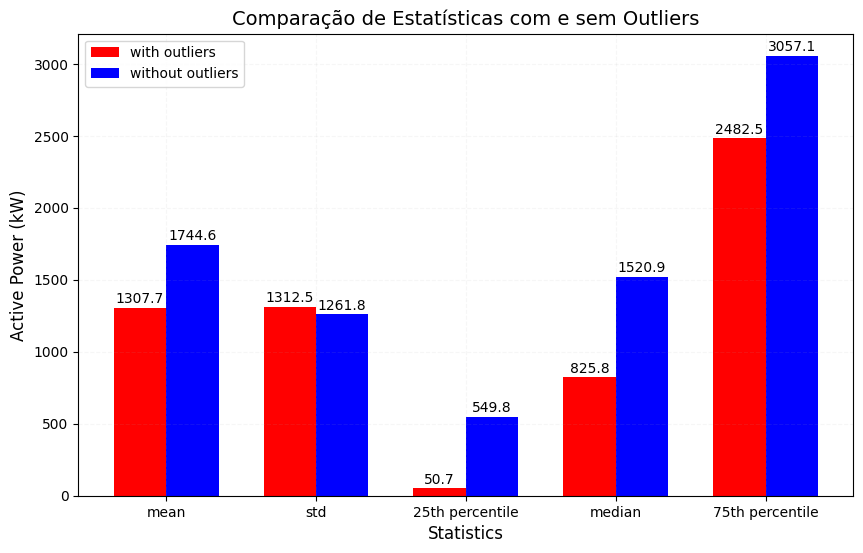

In [35]:
# Configurar barras
plt.figure(figsize=(10, 6))
barWidth = 0.35
r1 = range(len(resumo_estatistico))
r2 = [x + barWidth for x in r1]

# Criar o gráfico de barras
plt.bar(r1, resumo_estatistico['Active Power (kW)'], color='red', width=barWidth, label='with outliers')
plt.bar(r2, resumo_estatistico_so['Active Power (kW)'], color='blue', width=barWidth, label='without outliers')

# Adicionar rótulos às barras
plt.xlabel('Statistics', fontsize=12)
plt.ylabel('Active Power (kW)', fontsize=12)
plt.title('Comparação de Estatísticas com e sem Outliers', fontsize=14)
plt.xticks([r + barWidth/2 for r in range(len(resumo_estatistico))], list(resumo_estatistico_so.index), fontsize=10)
plt.yticks(fontsize=10)

# Adicionar legenda
plt.legend()

# Adicionar grids no gráfico
plt.grid(True, linestyle='--', alpha=0.1)

# Adicionar os valores máximos acima das barras no dataset com outliers
for i, value in enumerate(resumo_estatistico['Active Power (kW)']):
    plt.text(r1[i], value + 10, str(round(value, 1)), ha='center', va='bottom', fontsize=10, color='black')

# Adicionar os valores máximos acima das barras no dataset sem outliers
for i, value in enumerate(resumo_estatistico_so['Active Power (kW)']):
    plt.text(r2[i], value + 10, str(round(value, 1)), ha='center', va='bottom', fontsize=10, color='black')

# Exibir o gráfico
plt.show()

De acordo com o gráfico de barras, após a remoção dos *outliers*, houve um aumento da média e de todos os percentis. Isso já era esperado, uma vez que:

* Há uma grande quantidade de *outliers* com valores muito baixos (conforme mostrado no histograma). Dessa forma, uma vez removidos esses valores, a distribuição dos dados restantes agora é considerada a partir de valores mais elevados, ocasionando um aumento dos percentis. Além disso, como a média também sofre um aumento, já que esta é mais sensível à presença de valores extremos.

* Houve a redução da variabilidade dos dados, que é evidenciada pela redução no desvio padrão;

Apesar de ter havido uma leve redução no desvio padrão após a remoção dos *outliers*, este valor ainda está muito elevado. Isso confirma que a produção de energia nessa localidade é sazonal, provavelmente porque há uma alta variabilidade das condições de vento ao longo do ano.

## 3.5. Separação em conjunto de treino e conjunto de teste

É uma boa prática usar um conjunto de teste, uma amostra dos dados que não será usada para a construção do modelo, mas somente no fim do projeto para confirmar a precisão do modelo final. É um teste que podemos usar para verificar o quão boa foi a construção do modelo, e para nos dar uma ideia de como o modelo irá performar nas estimativas em dados não vistos.

Usaremos 80% do conjunto de dados para modelagem (training set) e guardaremos 20% para teste (test set), usando a estratégia train-test-split.

Primeiramente, iremos sinalizar quais são as colunas de features e qual é a coluna target. Em seguida, especificaremos o tamanho do conjunto de teste desejado e uma semente (para garantir a reprodutibilidade dos resultados).

Finalmente, faremos a separação dos conjuntos de treino e teste através do comando train_test_split, que retornará 4 estruturas de dados: features e target para o test set e features e target para o training set. Faremos experimentação no dataset original e também no dataset sem outliers.

In [36]:
test_size = 0.20
seed = 7

# Selecionar as colunas de interesse no dataset original organizado com colunas 'Date/Time' e 'Month' com outliers
features_selecionadas = ['Date/Time', 'Wind Speed (m/s)',
                         'Theoretical Power (kWh)', 'Wind Direction (°)']
target = ['Active Power (kW)']

# Converter DataFrame do pandas para arrays do NumPy
X = datasetTemporal[features_selecionadas].values
y = datasetTemporal[target].values

# Separação em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, # Features com outliers
    y, # Target sem outliers
    test_size=test_size,
    shuffle=True,
    random_state=seed)

# Padronização das características
# scaler = StandardScaler()
# X_train_standardized = scaler.fit_transform(X_train)
# X_test_standardized = scaler.transform(X_test)

# Normalização Min-Max das características
# scaler = MinMaxScaler()
# X_train_normalized = scaler.fit_transform(X_train)
# X_test_normalized = scaler.transform(X_test)

In [37]:
# Converter DataFrame do pandas para arrays do NumPy
X_so = datasetFiltrado[features_selecionadas].values
y_so = datasetFiltrado[target].values

# Separação em conjuntos de treino e teste
X_train_so, X_test_so, y_train_so, y_test_so = train_test_split(
    X_so, # Features sem outliers
    y_so, # Target sem outliers
    test_size=test_size,
    shuffle=True,
    random_state=seed)

# Padronização das características
# scaler = StandardScaler()
# X_train_so_standardized = scaler.fit_transform(X_train)
# X_test_so_standardized = scaler.transform(X_test)

# Normalização Min-Max das características
# scaler = MinMaxScaler()
# X_train_so_normalized = scaler.fit_transform(X_train)
# X_test_so_normalized = scaler.transform(X_test)

Em problemas de regressão como esse, o objetivo é prever valores contínuos em vez de classes discretas. Assim, a estratificação não é aplicada diretamente à variável target 'Active Power (kW)'. Em vez disso, vamos focar em garantir que a divisão entre conjuntos de treinamento e teste seja feita de maneira aleatória e representativa dos dados, de modo que o modelo seja treinado e testado em uma variedade de condições, refletindo a diversidade do seu conjunto de dados.

Finalmente, podemos utilizar a padronização ou a normalização dos datasets. A padronização ajuda a garantir que as diferentes características tenham escalas comparáveis, evitando que uma característica com uma escala maior tenha uma influência desproporcional no modelo. Isso garante convergência mais rápida em algoritmos baseados em gradiente e reduz a influência de outliers.

A normalização Min-Max preserva a distribuição relativa dos dados, mantendo os valores dentro de um intervalo específico, como 0 e 1. Isso pode ser útil quando se deseja manter a interpretação original dos dados e quando a escala absoluta não é crítica.

Nesse caso, faremos experimentos comparativos para avaliar o desempenho do modelo com ambas as técnicas. Iniciaremos com a padronização, podendo-se alterar para a normalização Min-Max, de acordo com o desempenho dos algoritmos.

#4. Conclusão

Neste MVP foi possível verificar que:

* Os dados contidos no dataset Wind Power SCADA apresentaram, em geral, boa qualidade.

* As inúmeras visualizações aplicadas para os atributos do dataset escolhido serviram para a construção de um entendimento global dos dados. A partir disso, foi possível traças estratégias de manipulação do dataset que foram realizadas em etapas posteriores.

* A abordagem de tratamento de *outliers* deve ser guiada pelo conhecimento do domínio, pelos objetivos da análise e pelas características específicas do conjunto de dados em questão. No dataset escolhido, valores *outliers* estão associados a condições específicas, como falhas temporárias ou períodos de baixo desempenho. Tratar esses valores de forma adequada ajuda mitigar o impacto dessas condições atípicas na análise geral.

* A remoção dos *outliers* de fato promoveu uma mudança importante nos dados estatísticos do dataset. Isso precisa ser levado em consideração durante a construção de futuros modelos. É importante conhecer a natureza do impacto dessa remoção para que nenhuma informação relevante seja perdida nessa fase de tratamento.

* A divisão entre conjuntos de treinamento e teste foi feita de maneira aleatória e representativa dos dados, de modo que o modelo seja treinado e testado em uma variedade de condições, refletindo a diversidade do seu conjunto de dados. Procedimentos como padronização e normalização serão utilizados em fases de experimentação para avaliar o impacto destes sobre o desempenho dos modelos.